In [1]:
import os
train_dir = "./train"
train_dogs_dir = f'{train_dir}/dogs'
train_cats_dir = f'{train_dir}/cats'
val_dir = "./val"
val_dogs_dir = f'{val_dir}/dogs'
val_cats_dir = f'{val_dir}/cats'
print("Printing data dir")
print(os.listdir(".")) # Shows train, val folders are under data
print("Printing train dir")
print(os.listdir(train_dir)[:5]) 
print("Printing train dog dir")
print(os.listdir(train_dogs_dir)[:5]) # Check the (empty) folder exist
print("Printing train cat dir")
print(os.listdir(train_cats_dir)[:5]) # Check the (empty) folder exist
print("Printing val dir")
print(os.listdir(val_dir)[:5]) # Shows subfolder dogs and cats exist
print("Printing val dog dir")
print(os.listdir(val_dogs_dir)[:5]) # Check the (empty) folder exist
print("Printing val cat dir")
print(os.listdir(val_cats_dir)[:5]) # Check the (empty) folder exist

Printing data dir
['.ipynb_checkpoints', 'cat_dog_tutorial.ipynb', 'sample_submission.csv', 'test', 'test.zip', 'train', 'train.zip', 'val']
Printing train dir
['cats', 'dogs']
Printing train dog dir
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.1000.jpg']
Printing train cat dir
['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.1000.jpg']
Printing val dir
['cats', 'dogs']
Printing val dog dir
['dog.5000.jpg', 'dog.5001.jpg', 'dog.5002.jpg', 'dog.5003.jpg', 'dog.5004.jpg']
Printing val cat dir
['cat.5000.jpg', 'cat.5001.jpg', 'cat.5002.jpg', 'cat.5003.jpg', 'cat.5004.jpg']


In [29]:
print(os.listdir('.'))

['.ipynb_checkpoints', 'cat_dog_tutorial.ipynb', 'sample_submission.csv', 'test', 'test.zip', 'train', 'train.zip', 'val']


In [21]:
import shutil
import re
files = os.listdir(train_dir)
# Move all train cat images to cats folder, dog images to dogs folder
for f in files:
    catSearchObj = re.search("cat", f)
    dogSearchObj = re.search("dog", f)
    if catSearchObj:
        shutil.move(f'{train_dir}/{f}', train_cats_dir)
    elif dogSearchObj:
        shutil.move(f'{train_dir}/{f}', train_dogs_dir)

In [22]:
print("Printing train dir") # shows cats, dogs subfolders only
print(os.listdir(train_dir)[:5])
print("Printing train dog dir") # there is now dog images in dogs folder
print(os.listdir(train_dogs_dir)[:5])
print("Printing train cat dir") # there is now cat images in cats folder
print(os.listdir(train_cats_dir)[:5])

Printing train dir
['cats', 'dogs']
Printing train dog dir
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.1000.jpg']
Printing train cat dir
['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.1000.jpg']


In [23]:
files = os.listdir(train_dogs_dir)
for f in files:
    validationDogsSearchObj = re.search("5\d\d\d", f)
    if validationDogsSearchObj:
        shutil.move(f'{train_dogs_dir}/{f}', val_dogs_dir)
print("Printing val dog dir")
print(os.listdir(val_dogs_dir)[:5])

Printing val dog dir
['dog.5000.jpg', 'dog.5001.jpg', 'dog.5002.jpg', 'dog.5003.jpg', 'dog.5004.jpg']


In [24]:
files = os.listdir(train_cats_dir)
for f in files:
    validationCatsSearchObj = re.search("5\d\d\d", f)
    if validationCatsSearchObj:
        shutil.move(f'{train_cats_dir}/{f}', val_cats_dir)
print("Printing val cat dir")
print(os.listdir(val_cats_dir)[:5])

Printing val cat dir
['cat.5000.jpg', 'cat.5001.jpg', 'cat.5002.jpg', 'cat.5003.jpg', 'cat.5004.jpg']


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math
print(torch.__version__)
plt.ion()   # interactive mode

1.5.1


In [9]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [270]:
data_dir = '.'
CHECK_POINT_PATH = 'checkpoint.tar'
#SUBMISSION_FILE = 'submission.csv'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                              shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names) # => ['cats', 'dogs']
print(f'Train image size: {dataset_sizes["train"]}')
print(f'Validation image size: {dataset_sizes["val"]}')

['cats', 'dogs']
Train image size: 23000
Validation image size: 2000


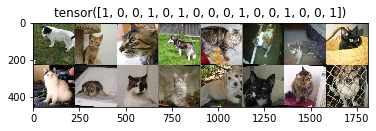

In [271]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
sample_train_images = torchvision.utils.make_grid(inputs)
imshow(sample_train_images, title=classes)

In [254]:
class ConvNet(nn.Module):
    
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size = 3, padding=0, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
            #nn.Dropout(0.2)
        )
        

        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size = 3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
            #nn.Dropout(0.2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size = 3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
            #nn.Dropout(0.2)
        )
        
        
        self.fc1 = nn.Linear(3*3*64,256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256,2)
        self.relu = nn.ReLU()

        
    def forward(self, x):
        
        out = self.layer1(x)
        #print(out.shape)
        
        out = self.layer2(out)
        #print(out.shape)
        
        out = self.layer3(out)
        #print(out.shape)
        
        out = out.reshape(out.size(0), -1)
        #print(out.shape)
        
        out = self.fc1(out)
        out = self.fc2(out)
        #print(out.shape)
        
        #return F.log_softmax(out, dim=-1)
        return out

In [255]:
model = ConvNet()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)
model.to(device)

cuda:0


ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=2, bias=True)

In [256]:
learning_rate = 0.001

criterion = nn.CrossEntropyLoss() 
#criterion = nn.NLLLoss()

optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate)#, momentum = 0.9)

In [257]:
epochs = 10

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    
    for data, label in dataloaders['train']:
        data = data.to(device)
        label = label.to(device)
        
        output = model(data)
        loss = criterion(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_accuracy += acc/len(dataloaders['train'])
        epoch_loss += loss/len(dataloaders['train'])
        
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
    
    
    with torch.no_grad():
        epoch_val_accuracy=0
        epoch_val_loss =0
        for data, label in dataloaders['val']:
            data = data.to(device)
            label = label.to(device)
            
            val_output = model(data)
            val_loss = criterion(val_output,label)
            
            
            acc = ((val_output.argmax(dim=1) == label).float().mean())
            epoch_val_accuracy += acc/ len(dataloaders['val'])
            epoch_val_loss += val_loss/ len('val')
            
        print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))

Epoch : 1, train accuracy : 0.6787961721420288, train loss : 0.6036410331726074
Epoch : 1, val_accuracy : 0.7539992928504944, val_loss : 83.86778259277344
Epoch : 2, train accuracy : 0.7607946395874023, train loss : 0.4947834610939026
Epoch : 2, val_accuracy : 0.7754990458488464, val_loss : 76.30400085449219
Epoch : 3, train accuracy : 0.7873607277870178, train loss : 0.4514462351799011
Epoch : 3, val_accuracy : 0.7924992442131042, val_loss : 75.24629211425781
Epoch : 4, train accuracy : 0.8094485402107239, train loss : 0.42094090580940247
Epoch : 4, val_accuracy : 0.7924991846084595, val_loss : 74.28132629394531
Epoch : 5, train accuracy : 0.8202328681945801, train loss : 0.3984719514846802
Epoch : 5, val_accuracy : 0.8149991035461426, val_loss : 69.29701232910156
Epoch : 6, train accuracy : 0.8281456232070923, train loss : 0.37656715512275696
Epoch : 6, val_accuracy : 0.8259987235069275, val_loss : 64.3201675415039
Epoch : 7, train accuracy : 0.8372772932052612, train loss : 0.365489

In [258]:
#exploring the number of parameters depending in the last linear layer
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)


In [259]:
pytorch_total_params #128, 97922; 256, 172034; 10, 29600; 1024, 616706;

172034

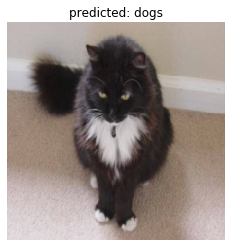

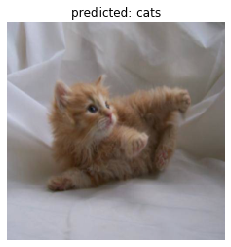

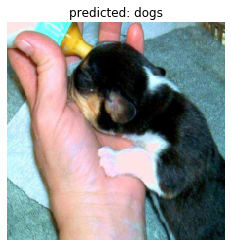

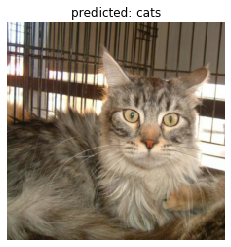

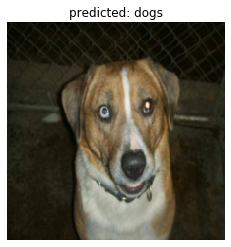

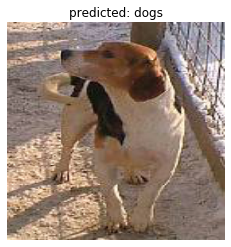

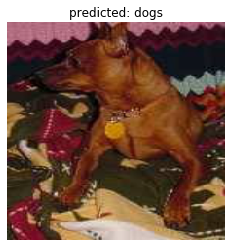

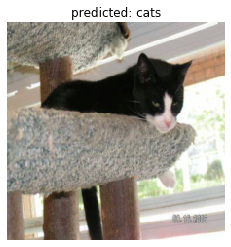

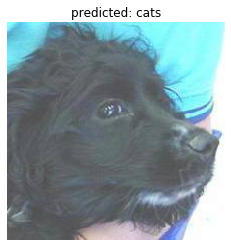

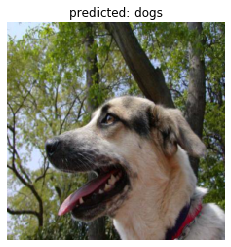

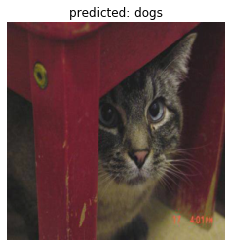

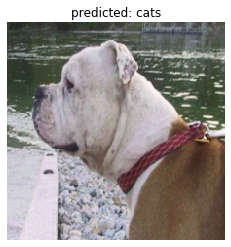

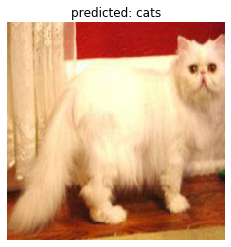

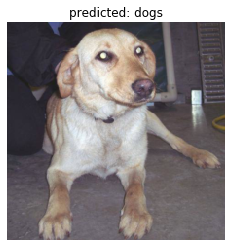

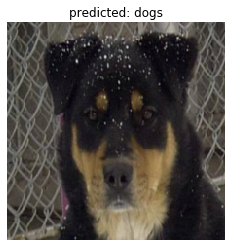

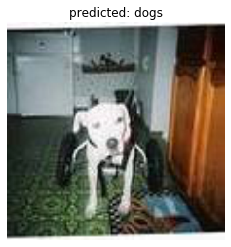

In [314]:
def visualize_model(model, num_images=24):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot()
        ax.axis('off')
        ax.set_title('predicted: {}'.format(class_names[preds[j]]))
        imshow(inputs.cpu().data[j])
        if images_so_far == num_images:
            model.train(mode=was_training)
            return
    model.train(mode=was_training)
visualize_model(model)
plt.ioff()
plt.show()